Check Python version

In [1]:
!python --version

Python 3.8.17


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [4]:
train_df = pd.read_csv(file_name)

In [5]:
train_df.shape

(144, 2)

In [6]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [7]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [9]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [10]:
train_df[target_col] = train_df[target_col].astype(float)

In [11]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

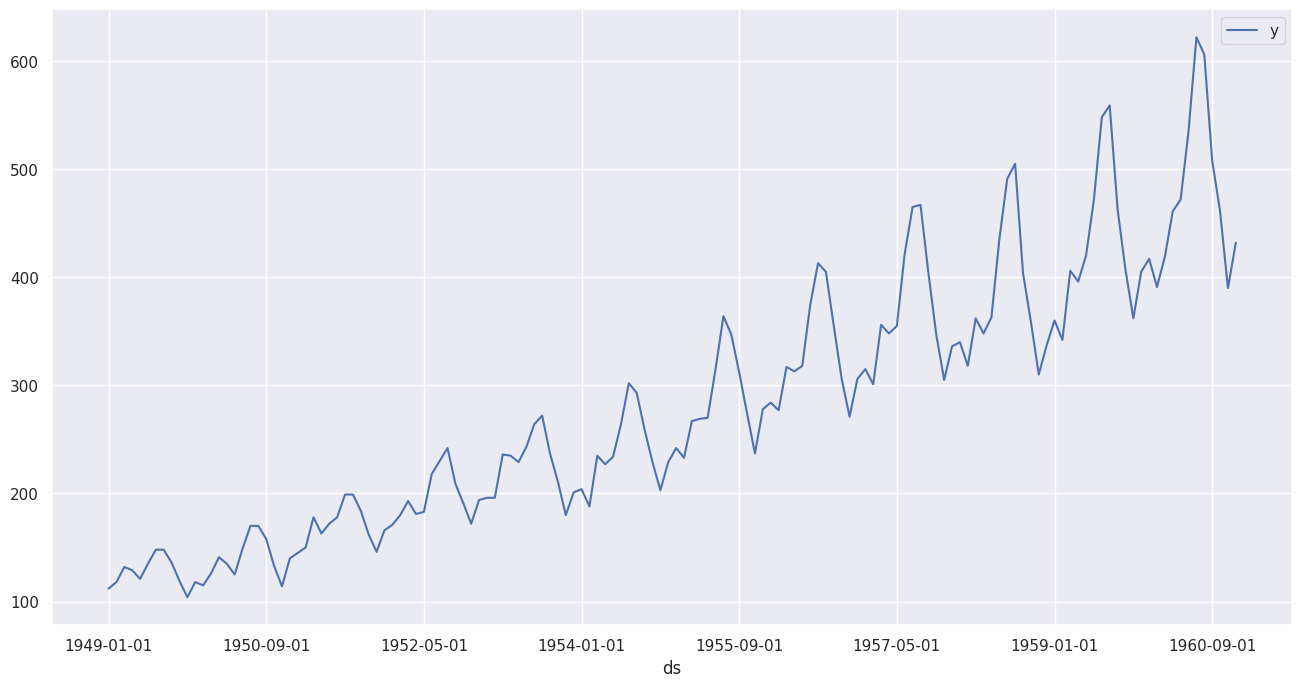

In [12]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [13]:
train_data = []

In [14]:
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [16]:
# Default model request
# model_request = {
#     'type': 'meta_lr',  # 'meta_wa'
#     'scorers': ['smape', 'mape'],
#     'params': {
#         'preprocessors': [
#             {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_autoets'},
#             # {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

# Customized model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mape'],
#     'param': {
#         'base_models': [
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoets'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

Train API JSON Payload

In [17]:
api_json = {
    'data': train_data,
    # 'model': model_request  # (optional) can be commented out
}

Build URL

In [18]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [19]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [20]:
protocol, host, port

('https', 'sybil-test.tempor.ai', 443)

Call endpoint, receive response JSON, write to output file

In [21]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

SSLError: HTTPSConnectionPool(host='sybil-test.tempor.ai', port=443): Max retries exceeded with url: /train (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1131)')))

In [22]:
train_json_out = response.json()  # dict output
train_json_out

NameError: name 'response' is not defined

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [ ]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [ ]:
model = train_json_out['model']

Forecast API JSON Payload

In [ ]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [ ]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [ ]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

In [ ]:
forecast_json_out = response.json()  # dict output
forecast_json_out

Combine forecast dates and output

In [ ]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [ ]:
forecast_df.shape

In [ ]:
forecast_df.columns

In [ ]:
forecast_df.head()

In [ ]:
forecast_df.tail()

Plot train and forecast side-by-side

In [ ]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

In [ ]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and test sets

In [ ]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.tail()

Plot combined train and test sets with the vertical black line as the cut-off

In [ ]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Test: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();